Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import random
from IPython.display import display # Untuk menampilkan gambar di Jupyter/IPython
from sklearn.model_selection import train_test_split # Untuk split data
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Untuk memproses gambar ke NumPy array
from tqdm import tqdm # Untuk progress bar
from collections import Counter # Untuk kombinasi label

Global Configuration

In [3]:
LABELS_FINAL = ['battery', 'organik', 'glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']
LABEL_MAP = {
    # Kaggle
    'battery': 'battery',
    'biological': 'organik',
    'brown-glass': 'glass',
    'white-glass': 'glass',
    'green-glass': 'glass',
    'clothes': 'trash',
    'shoes': 'trash',
    'metal': 'metal',
    'paper': 'paper',
    'cardboard': 'cardboard',
    'plastic': 'plastic',
    'trash': 'trash',
    # TrashNet
    'glass': 'glass'
}

# Path Dasar untuk Dataset (Sesuaikan jika struktur folder berbeda)
# Asumsi notebook berada di 'notebooks/' dan dataset di 'dataset/'
BASE_DIR_DATASET = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
LABELS_CSV_PATH = os.path.join(BASE_DIR_DATASET, 'labels.csv')
IMAGES_DIR_PATH = os.path.join(BASE_DIR_DATASET, 'images')
CLEAN_CSV_PATH = os.path.join(BASE_DIR_DATASET, 'labels_clean.csv') # Path untuk CSV bersih

# Konfigurasi Ukuran Gambar untuk Model
IMG_SIZE = (224, 224) # Ukuran gambar target untuk model CNN


Load Dataset

In [4]:
print("--- 1. Memuat Dataset ---")
try:
    df = pd.read_csv(LABELS_CSV_PATH)
    print("DataFrame head:")
    display(df.head())
    print(f"Dataset dimuat. Total sampel: {len(df)}")
except FileNotFoundError:
    print(f"Error: File '{LABELS_CSV_PATH}' tidak ditemukan. Pastikan Anda telah menjalankan skrip pembuatan dataset.")
    exit() # Ini akan menghentikan eksekusi notebook/skrip jika file utama tidak ditemukan

# Pastikan LABELS adalah kolom-kolom label, bukan 'filename'
LABELS = df.columns.tolist()[1:]

print(f"\nJumlah label yang dikenali: {len(LABELS)}")
print("Daftar Label:", LABELS)

# --- (Opsional) Pengecekan Duplikat / Gambar Identik ---
print("\n--- (Opsional) Pengecekan Duplikat Nama File ---")
duplikat_filenames = df['filename'].duplicated().sum()
if duplikat_filenames > 0:
    print(f"Peringatan: Ada {duplikat_filenames} nama file duplikat di dataset!")
    print("Pertimbangkan untuk menangani ini jika ini tidak diinginkan (misalnya, hapus duplikat).")
else:
    print("Tidak ada nama file duplikat yang ditemukan.")

# --- (Opsional) Pengecekan Duplikat Label ---
print("\n--- (Opsional) Pengecekan Duplikat Label ---")
duplikat_labels = df[LABELS].duplicated().sum()
if duplikat_labels > 0:
    print(f"Peringatan: Ada {duplikat_labels} duplikat label di dataset!")
    print("Pertimbangkan untuk menangani ini jika ini tidak diinginkan (misalnya, hapus duplikat).")
else:
    print("Tidak ada duplikat label yang ditemukan.")

# --- (Opsional) Pengecekan Label Kosong ---
print("\n--- (Opsional) Pengecekan Label Kosong ---")
label_kosong = df[LABELS].isnull().sum().sum()
if label_kosong > 0:
    print(f"Peringatan: Ada {label_kosong} label kosong di dataset!")
    print("Pertimbangkan untuk menangani ini jika ini tidak diinginkan (misalnya, mengisi dengan nilai default).")
else:
    print("Tidak ada label kosong yang ditemukan.")

--- 1. Memuat Dataset ---
DataFrame head:


,filename,battery,organik,glass,cardboard,metal,paper,plastic,trash
0,img_0000.jpg,0,0,0,1,1,0,0,0
1,img_0001.jpg,1,1,0,0,0,0,0,0
2,img_0002.jpg,0,1,1,0,0,0,0,0
3,img_0003.jpg,0,0,1,0,1,0,0,0
4,img_0004.jpg,0,0,1,1,0,0,0,0


Dataset dimuat. Total sampel: 4992

Jumlah label yang dikenali: 8
Daftar Label: ['battery', 'organik', 'glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']

--- (Opsional) Pengecekan Duplikat Nama File ---
Tidak ada nama file duplikat yang ditemukan.

--- (Opsional) Pengecekan Duplikat Label ---
Peringatan: Ada 4838 duplikat label di dataset!
Pertimbangkan untuk menangani ini jika ini tidak diinginkan (misalnya, hapus duplikat).

--- (Opsional) Pengecekan Label Kosong ---
Tidak ada label kosong yang ditemukan.


Analisis


--- 2. Analisis Distribusi Label ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21300\2885195100.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


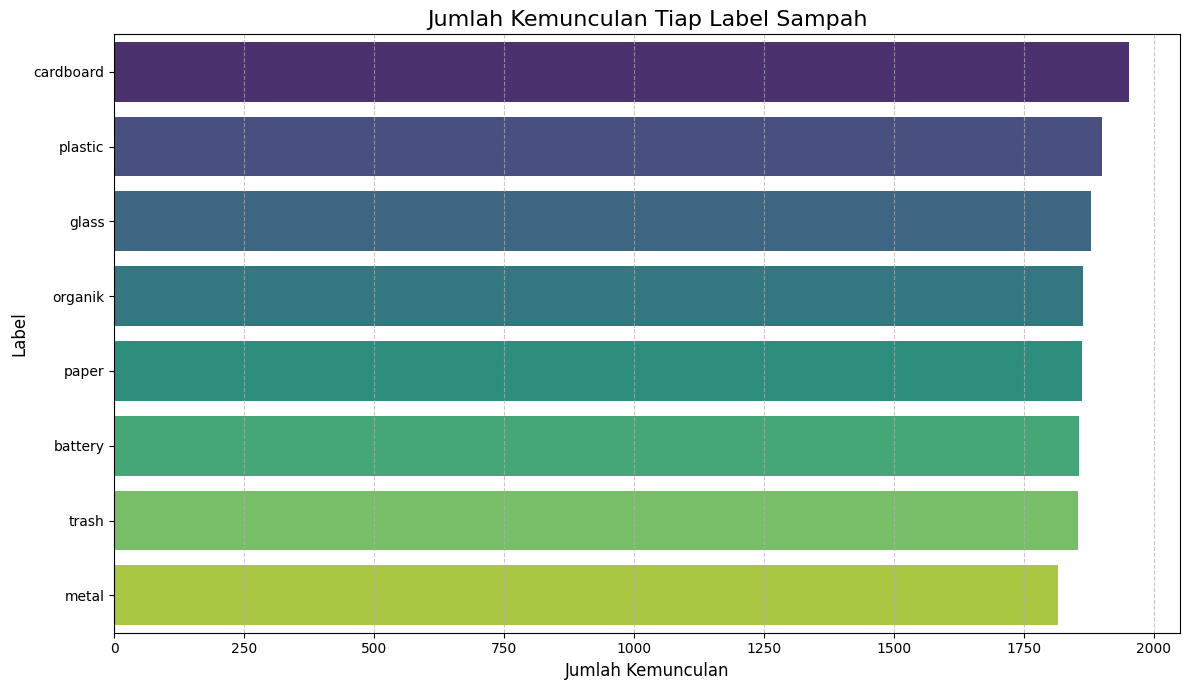


Detail Kemunculan Tiap Label:
- cardboard : 1953 kali
- plastic   : 1900 kali
- glass     : 1879 kali
- organik   : 1864 kali
- paper     : 1862 kali
- battery   : 1856 kali
- trash     : 1854 kali
- metal     : 1815 kali

(Opsional) Rasio Kemunculan Setiap Label (% dari total gambar):
cardboard    39.12%
plastic      38.06%
glass        37.64%
organik      37.34%
paper        37.30%
battery      37.18%
trash        37.14%
metal        36.36%


In [5]:
print("\n--- 2. Analisis Distribusi Label ---")
label_counts = df[LABELS].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.title("Jumlah Kemunculan Tiap Label Sampah", fontsize=16)
plt.xlabel("Jumlah Kemunculan", fontsize=12)
plt.ylabel("Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nDetail Kemunculan Tiap Label:")
for label, count in label_counts.items():
    print(f"- {label:<10}: {int(count)} kali")

print("\n(Opsional) Rasio Kemunculan Setiap Label (% dari total gambar):")
ratios = label_counts / len(df)
print(ratios.apply(lambda x: f"{x*100:.2f}%").to_string())



Analisis Multi-Label Per Gambar


--- 3. Analisis Multi-Label Per Gambar ---


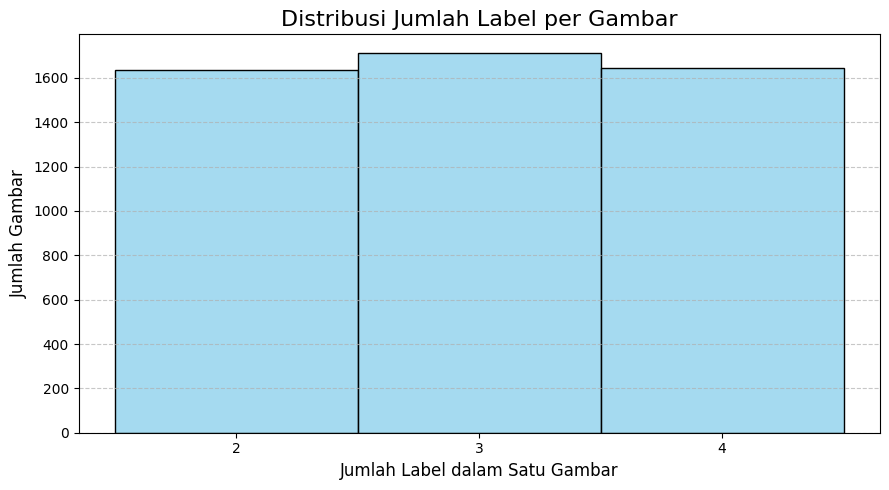


Detail Distribusi Jumlah Label per Gambar:
num_labels
2    1637
3    1711
4    1644
Name: count, dtype: int64

--- (Opsional) Analisis Kombinasi Label Paling Umum ---

Top 10 Kombinasi Label Paling Umum:
- cardboard, paper: 76 gambar
- cardboard, trash: 70 gambar
- organik, cardboard: 70 gambar
- cardboard, plastic: 67 gambar
- organik, metal: 64 gambar
- battery, glass: 64 gambar
- cardboard, metal: 62 gambar
- battery, organik: 62 gambar
- metal, paper: 62 gambar
- plastic, trash: 62 gambar


In [6]:
print("\n--- 3. Analisis Multi-Label Per Gambar ---")
df['num_labels'] = df[LABELS].sum(axis=1)

plt.figure(figsize=(9, 5))
sns.histplot(df['num_labels'], bins=range(df['num_labels'].min(), df['num_labels'].max() + 2), discrete=True, color='skyblue', edgecolor='black')
plt.title("Distribusi Jumlah Label per Gambar", fontsize=16)
plt.xlabel("Jumlah Label dalam Satu Gambar", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(range(df['num_labels'].min(), df['num_labels'].max() + 1), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nDetail Distribusi Jumlah Label per Gambar:")
print(df['num_labels'].value_counts().sort_index())

print("\n--- (Opsional) Analisis Kombinasi Label Paling Umum ---")
label_combo_indices = df[LABELS].apply(lambda row: tuple(np.where(row == 1)[0]), axis=1)
combo_counter = Counter(label_combo_indices)

most_common_combos = combo_counter.most_common(10)

print("\nTop 10 Kombinasi Label Paling Umum:")
for combo_indices, count in most_common_combos:
    labels_in_combo = [LABELS[i] for i in combo_indices]
    print(f"- {', '.join(labels_in_combo)}: {count} gambar")

Tampilkan Contoh Gambar + Label


--- 4. Menampilkan Contoh Gambar + Label ---

--- Sampel 2722 ---
Filename: img_2722.jpg
Labels: ['battery', 'glass', 'cardboard', 'plastic']


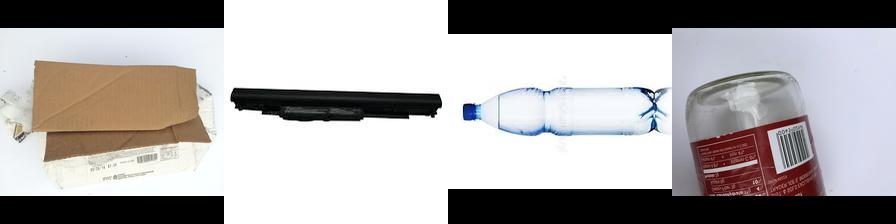


--- Sampel 4539 ---
Filename: img_4545.jpg
Labels: ['organik', 'metal', 'trash']


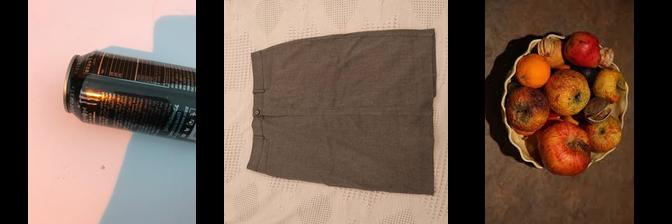


--- Sampel 2875 ---
Filename: img_2875.jpg
Labels: ['cardboard', 'metal', 'plastic', 'trash']


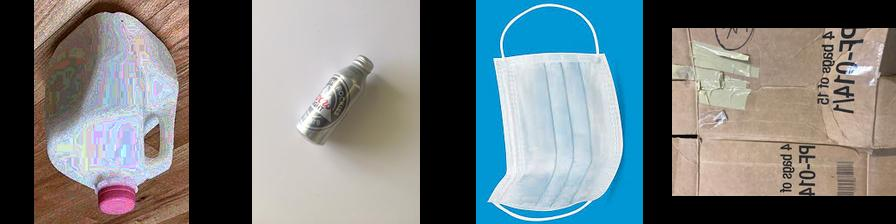


--- Sampel 4387 ---
Filename: img_4393.jpg
Labels: ['battery', 'glass']


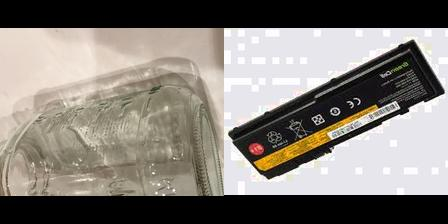


--- Sampel 372 ---
Filename: img_0371.jpg
Labels: ['battery', 'organik', 'cardboard']


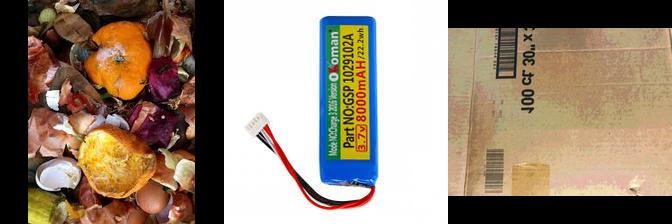

In [7]:
print("\n--- 4. Menampilkan Contoh Gambar + Label ---")
def show_random_image(dataframe, num_samples=3):
    """Menampilkan sejumlah acak gambar dari DataFrame bersama labelnya."""
    samples = dataframe.sample(num_samples)
    for i, row in samples.iterrows():
        img_path = os.path.join(IMAGES_DIR_PATH, row['filename'])
        try:
            img = Image.open(img_path)
            print(f"\n--- Sampel {i+1} ---")
            print(f"Filename: {row['filename']}")
            active_labels = [label for label in LABELS if row[label] == 1]
            print("Labels:", active_labels if active_labels else "Tidak ada label (Anomali?)")
            display(img)
        except FileNotFoundError:
            print(f"\n--- Sampel {i+1} ---")
            print(f"Error: Gambar '{row['filename']}' tidak ditemukan di {IMAGES_DIR_PATH}.")
        except Exception as e:
            print(f"\n--- Sampel {i+1} ---")
            print(f"Error saat memuat atau menampilkan gambar '{row['filename']}': {e}")

show_random_image(df, num_samples=5)

Validasi Data : Cek File Gambar yang Hilang

In [8]:
print("\n--- 5. Memvalidasi Data: Mengecek File Gambar yang Hilang ---")
missing_files = []
for fname in tqdm(df['filename'], desc="Mengecek file hilang"):
    if not os.path.exists(os.path.join(IMAGES_DIR_PATH, fname)):
        missing_files.append(fname)

print(f"Jumlah gambar hilang: {len(missing_files)}")
if missing_files:
    print("Beberapa gambar hilang (5 contoh pertama):")
    for f in missing_files[:5]:
        print(f"- {f}")
    df_clean = df[~df['filename'].isin(missing_files)].reset_index(drop=True)
    print(f"DataFrame diperbarui, {len(missing_files)} file hilang dihapus. Total sampel baru: {len(df_clean)}")
    df = df_clean # Perbarui df utama
    
    print(f"Menyimpan DataFrame tanpa gambar hilang ke {CLEAN_CSV_PATH}")
    df.to_csv(CLEAN_CSV_PATH, index=False)
else:
    print("Tidak ada gambar yang hilang. Semua file ditemukan.")
    df_clean = df # Jika tidak ada yang hilang, df_clean sama dengan df


--- 5. Memvalidasi Data: Mengecek File Gambar yang Hilang ---


Mengecek file hilang: 100%|██████████| 4992/4992 [00:00<00:00, 11832.43it/s]

Jumlah gambar hilang: 0
Tidak ada gambar yang hilang. Semua file ditemukan.


Konversi dan Penyimpanan data dalam format NumPy Array

In [9]:
print("\n--- 6. Mengonversi dan Menyimpan Data dalam Format NumPy Array ---")

X_DATA_PATH = os.path.join(BASE_DIR_DATASET, 'X_data.npy')
Y_LABELS_PATH = os.path.join(BASE_DIR_DATASET, 'Y_labels.npy')

X = []
Y = []
corrupted_images_during_load = []

for idx, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Memproses gambar untuk NumPy array"):
    path = os.path.join(IMAGES_DIR_PATH, row['filename'])
    try:
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0 # Normalisasi
        X.append(img_array)
        Y.append(row[LABELS].values.astype(np.float32))
    except Exception as e:
        corrupted_images_during_load.append(row['filename'])
        print(f"\nPeringatan: Gagal memuat atau memproses gambar {row['filename']}: {e}. Melewatkan.")
        continue

if not X:
    print("Tidak ada gambar yang berhasil dimuat untuk konversi NumPy array. Pastikan IMAGES_DIR_PATH dan LABELS_CSV_PATH sudah benar.")
    exit()
else:
    X = np.array(X)
    Y = np.array(Y)

    print(f"\nBentuk X (data gambar): {X.shape}")
    print(f"Bentuk Y (label): {Y.shape}")

    np.save(X_DATA_PATH, X)
    np.save(Y_LABELS_PATH, Y)
    print(f"Data gambar disimpan ke {X_DATA_PATH}")
    print(f"Data label disimpan ke {Y_LABELS_PATH}")

    if corrupted_images_during_load:
        print(f"\n{len(corrupted_images_during_load)} gambar tidak dapat dimuat/diproses.")
        # Bisa tambahkan logging ke file di sini
    else:
        print("\nSemua gambar berhasil dikonversi ke NumPy array.")

print("\n--- Data Preprocessing & Visualisasi Selesai ---")


--- 6. Mengonversi dan Menyimpan Data dalam Format NumPy Array ---


Memproses gambar untuk NumPy array: 100%|██████████| 4992/4992 [01:38<00:00, 50.63it/s]



Bentuk X (data gambar): (4992, 224, 224, 3)
Bentuk Y (label): (4992, 8)
Data gambar disimpan ke d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\X_data.npy
Data label disimpan ke d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\Y_labels.npy

Semua gambar berhasil dikonversi ke NumPy array.

--- Data Preprocessing & Visualisasi Selesai ---
